# Chladni Modes and Laplacian Spectrum

In [1]:
%matplotlib inline
#
from lrgsglib.core import *
#
move_to_rootf()
plt.style.use('ipynb/nb_plotsheet.mplstyle')
#
path_chladni = PATHDATA / 'chladni'
path_cluster_chladni = PATHDATA / 'cluster_data' / 'chladni'
path_plotchladni = PATHPLOT / 'chladni'

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


### Antiferro Reconstruction

In [15]:
T = 0.
geo = 'tri'
pflip = 1
remove_files = False
side = 64

In [16]:
l_tri_recon = Lattice2D(side, geo=geo, pflip=1)
l_tri_recon.flip_random_fract_edges()
l_tri_recon.compute_k_eigvV(with_routine='numpy')

In [24]:
isdy = IsingDynamics(l_tri_recon, T=T, ic='uniform', runlang='C3', 
                     rndStr=True, thrmSTEP=80)
isdy.init_ising_dynamics(exName=isdy.id_string_isingdyn)
l_tri_recon.export_edgel_bin()
isdy.run()
if remove_files:
    isdy.remove_run_c_files(remove_stderr=True)
    l_tri_recon.remove_exported_files()

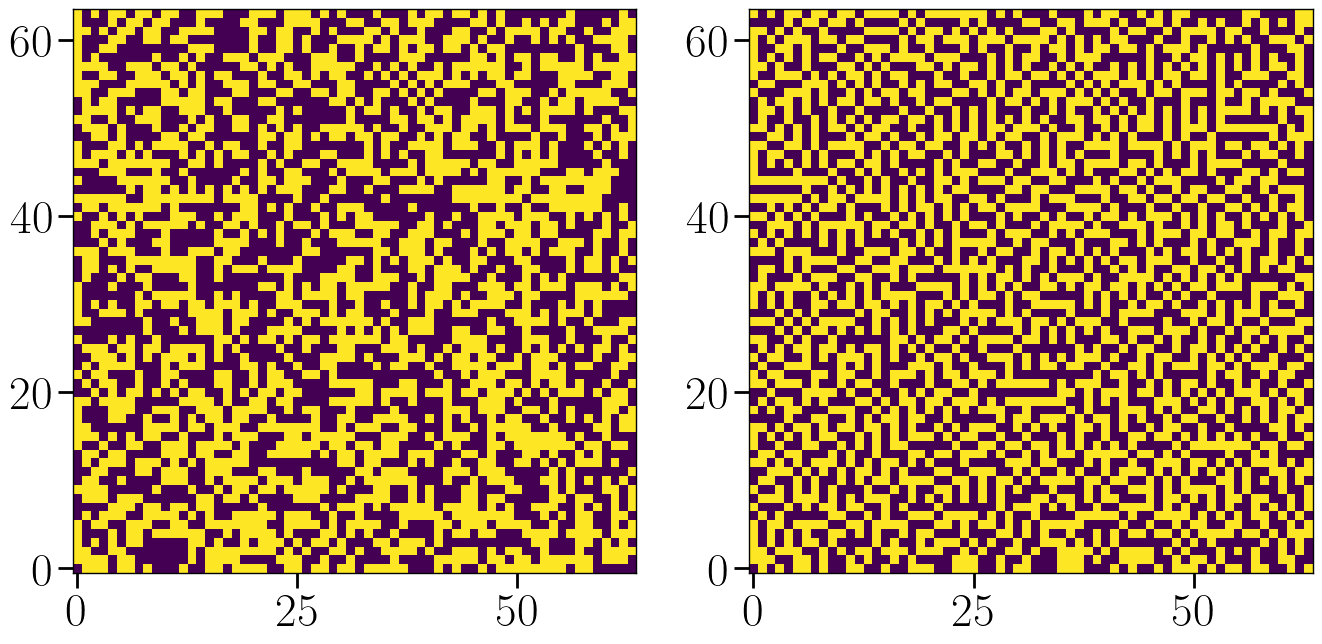

In [25]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(isdy.s_0.reshape(*l_tri_recon.syshape))
ax[1].imshow(isdy.s.reshape(*l_tri_recon.syshape))

- nello spazio degli autostati che maggiormente lo rappresentano vederne gli attrattori: prendi ad ogni tempo i principali autostati (quelli con componenti piu grandi)

In [41]:
matproj = isdy.s.reshape(*l_tri_recon.syshape)
p_overlap = []
for i in range(0, 2048, 128):
    basis = np.array([l_tri_recon.eigV[i].reshape(*l_tri_recon.syshape) for i in range(0, i+1)])
    projections = np.array(matrix_projection(matproj, basis))
    recon = np.sign(reconstruct_from_projections(projections, basis))
    p_overlap.append(spin_overlap(isdy.s.reshape(*l_tri_recon.syshape), recon))


In [ ]:
X = np.linspace(0, 2048, 2048//128)
plt.plot(X/4096, p_overlap)
plt.plot(X/4096, 0.02*X**(1/1.999))

In [39]:
# overlap = np.array([spin_overlap(isdy.s.reshape(*l.syshape),l.get_eigV_bin_check(i).reshape(*l.syshape)) for i in range(l.N)])
# sorted_args = np.argsort(overlap)[::-1]
matproj = isdy.s.reshape(*l_tri_recon.syshape)
basis = np.array([l_tri_recon.eigV[i].reshape(*l_tri_recon.syshape) for i in range(0, 1024)])
projections = np.array(matrix_projection(matproj, basis))

0.6962890625


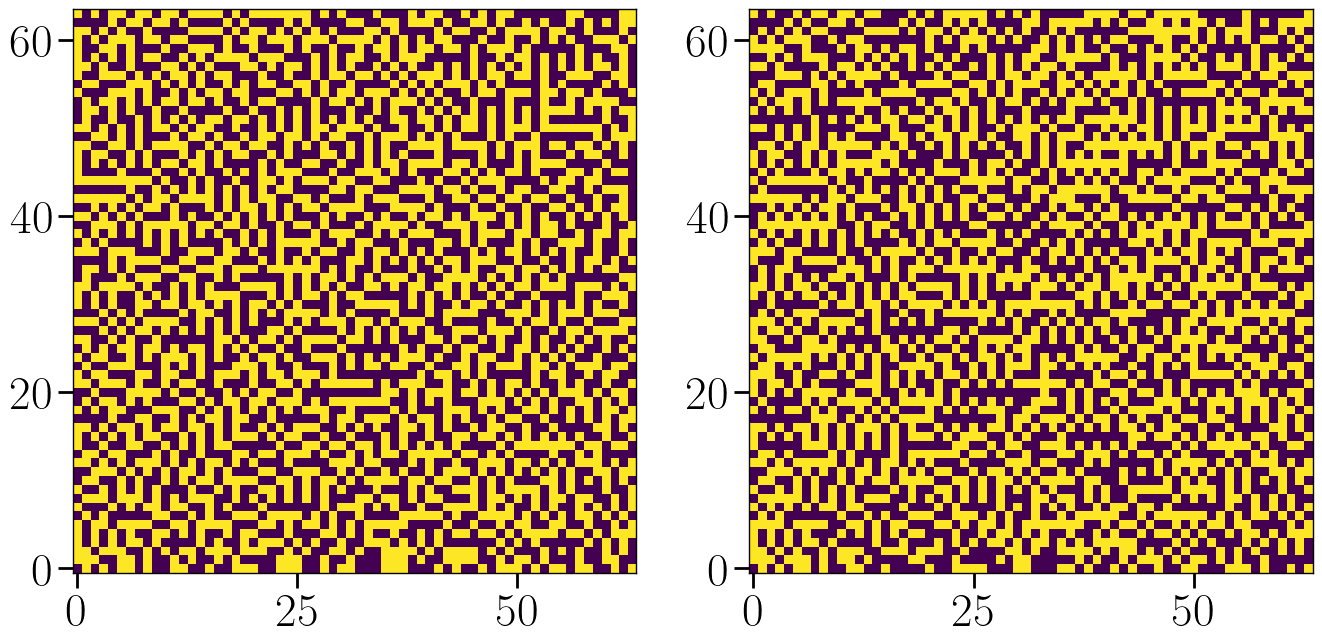

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
recon = np.sign(reconstruct_from_projections(projections, basis))
ax[1].imshow(recon, origin='lower')
ax[0].imshow(isdy.s.reshape(*l_tri_recon.syshape), origin='lower')
p_overlap = spin_overlap(isdy.s.reshape(*l_tri_recon.syshape), recon)
print(p_overlap)

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(3):
    ax[i].imshow(-l.get_eigV_bin_check(sorted_args[i]).reshape(*l.syshape), origin='lower')
    ax[i].axis('off')
    ax[i].set_title(f'{sorted_args[i]}')
ax[3].imshow(isdy.s.reshape(*l.syshape), origin='lower')
ax[3].axis('off')
ax[4].imshow(np.sign(reconstruct_from_projections(projections, basis)), origin='lower')
ax[4].axis('off')

## SL

In [ ]:
lsl = Lattice2D(64, pflip=0.2, geo='sqr')
lsl.flip_random_fract_edges()

In [ ]:
lsl.compute_k_eigvV(with_routine='numpy')

In [ ]:
isdy = IsingDynamics(lsl, T=0.5, ic='uniform', runlang='C3', rndStr=True)

In [ ]:
isdy.init_ising_dynamics()
lsl.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.export_ising_clust()
isdy.run(verbose=False, thrmSTEP=80)
if remove_files:
    isdy.remove_run_c_files(remove_stderr=True)
    lsl.remove_edgl_file()

In [ ]:
matproj = isdy.s.reshape(*lsl.syshape)
basis = np.array([lsl.eigV[i].reshape(*lsl.syshape) for i in range(256)])
projections = np.array(matrix_projection(matproj, basis))

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
recon = np.sign(reconstruct_from_projections(projections, basis))
ax[0].imshow(recon, origin='lower')
ax[1].imshow(isdy.s.reshape(*l_tri_recon.syshape), origin='lower')
p_overlap = spin_overlap(isdy.s.reshape(*l_tri_recon.syshape), recon)
print(p_overlap)

In [ ]:
ll = Lattice2D(64)
ll.compute_k_eigvV(with_routine='numpy')

In [ ]:
plt.imshow(np.abs(ll.eigV[0].reshape(*ll.syshape)), origin='lower')

## Trash

In [ ]:
T = 0.0
geo = 'sqr'
pflip = 0
remove_files = False

In [ ]:
l = Lattice2D(64, pflip=pflip, geo=geo)
l.flip_random_fract_edges()
l.compute_k_eigvV(with_routine='numpy')

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(10, 3.5))
count = 0
for i in range(3):
    for j in range(5):
        ax[i, j].imshow(l.get_eigV_bin_check(count).reshape(*l.syshape), origin='lower')
        ax[i, j].axis('off')
        ax[i, j].set_title(f'{count}')
        count += 1

In [ ]:
test_ene = [l.get_rbim_energy_eigV(_)/(2*l.N) for _ in range(l.N)]
plt.plot(test_ene, 'o', ms=0.5)

In [ ]:
isdy = IsingDynamics(l, T=T, ic='ground_state_0', runlang='C3', rndStr=True)
isdy.init_ising_dynamics()
l.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.export_ising_clust()
isdy.run(verbose=False, thrmSTEP=200)
if remove_files:
    isdy.remove_run_c_files(remove_stderr=True)
    l.remove_edgl_file()

In [ ]:
4096*3000

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(l.get_eigV_bin_check(1023).reshape(*l.syshape))
ax[1].imshow(isdy.s.reshape(*l.syshape))

In [ ]:
np.exp(-1/0.1), 1/4096

In [ ]:
ene = np.fromfile(l.isingpath /Path('ene_p=0_T=0_.bin'), dtype=np.float64)

In [ ]:
l.get_rbim_energy_eigV(2048)/(2*l.N)

In [ ]:
plt.plot(ene/(4))
# plt.yscale('symlog')
plt.xscale('symlog')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(isdy.s.reshape(*l.syshape), origin='lower')
ax.axis('off')

In [ ]:
overlap = np.array([spin_overlap(isdy.s.reshape(*l.syshape),l.get_eigV_bin_check(i).reshape(*l.syshape)) for i in range(l.N)])
sorted_args = np.argsort(overlap)[::-1]
matproj = isdy.s.reshape(*l.syshape)
basis = np.array([l.eigV[i].reshape(*l.syshape) for i in sorted_args[:500]])
projections = np.array(matrix_projection(matproj, basis))

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(3):
    ax[i].imshow(-l.get_eigV_bin_check(sorted_args[i]).reshape(*l.syshape), origin='lower')
    ax[i].axis('off')
    ax[i].set_title(f'{sorted_args[i]}')
ax[3].imshow(isdy.s.reshape(*l.syshape), origin='lower')
ax[3].axis('off')
ax[4].imshow(np.sign(reconstruct_from_projections(projections, basis)), origin='lower')
ax[4].axis('off')

In [ ]:
spin_overlap(isdy.s.reshape(*l.syshape), np.sign(reconstruct_from_projections(projections, basis)))